In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorboard as tb

# Loading Sample Tensorboard Output
The sample output file from Tensorboard in this current directory can, of course, be loaded into the Tensorboard suite in the browser. To do this, simply download the raw file into some directory, open a terminal session in that directory, and run the following (assuming `tensorboard` is installed):
```shell
tensorboard --port 6060 --logdir .
```

After running that command, you then just need to go to [http://localhost:6060/]() to view the results in TensorBoard. However, these results can also be loaded as a `pandas.DataFrame`, which is what we do in this notebook.

In [2]:
from packaging import version

major_ver, minor_ver, _ = version.parse(tb.__version__).release
assert major_ver >= 2 and minor_ver >= 3, \
    "This notebook requires TensorBoard 2.3 or later"
print(f"TensorBoard version: ", tb.__version__)

TensorBoard version:  2.10.1


## Implementation: Pure TensorFlow/TensorBoard
Unfortunately, to parse the `.tfevents` files, you need to import `tensorflow`. Below is an implementation of conversion to a `pandas.DataFrame` with just pure TF/TB. The implementation was provided by:
https://laszukdawid.com/blog/2021/01/26/parsing-tensorboard-data-locally/

In [3]:
def convert_tb_data(root_dir, sort_by=None):
    """Convert local TensorBoard data into Pandas DataFrame.
    
    Function takes the root directory path and recursively parses
    all events data.    
    If the `sort_by` value is provided then it will use that column
    to sort values; typically `wall_time` or `step`.
    
    *Note* that the whole data is converted into a DataFrame.
    Depending on the data size this might take a while. If it takes
    too long then narrow it to some sub-directories.
    
    Paramters:
        root_dir: (str) path to root dir with tensorboard data.
        sort_by: (optional str) column name to sort by.
    
    Returns:
        pandas.DataFrame with [wall_time, name, step, value] columns.
    
    """
    import os
    import pandas as pd
    from tensorflow.python.summary.summary_iterator import summary_iterator

    def convert_tfevent(filepath):
        return pd.DataFrame([
            parse_tfevent(e) for e in summary_iterator(filepath) if len(e.summary.value)
        ])

    def parse_tfevent(tfevent):
        return dict(
            wall_time=tfevent.wall_time,
            name=tfevent.summary.value[0].tag,
            step=tfevent.step,
            value=float(tfevent.summary.value[0].simple_value),
        )
    
    columns_order = ['wall_time', 'name', 'step', 'value']
    
    out = []
    for (root, _, filenames) in os.walk(root_dir):
        for filename in filenames:
            if "events.out.tfevents" not in filename:
                continue
            file_full_path = os.path.join(root, filename)
            out.append(convert_tfevent(file_full_path))

    # Concatenate (and sort) all partial individual dataframes
    all_df = pd.concat(out)[columns_order]
    if sort_by is not None:
        all_df = all_df.sort_values(sort_by)
        
    return all_df.reset_index(drop=True)
    

In [4]:
experiment = "events.out.tfevents.1691409406.x3209c0s19b0n0.34463.0"
df = convert_tb_data(".")
df.head()

2023-08-09 13:32:19.999376: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


,wall_time,name,step,value
0,1.691410e+09,train_loss,49,0.836164
1,1.691410e+09,epoch,49,0.000000
2,1.691410e+09,train_loss,99,0.123193
3,1.691410e+09,epoch,99,0.000000
4,1.691410e+09,train_loss,149,0.122065


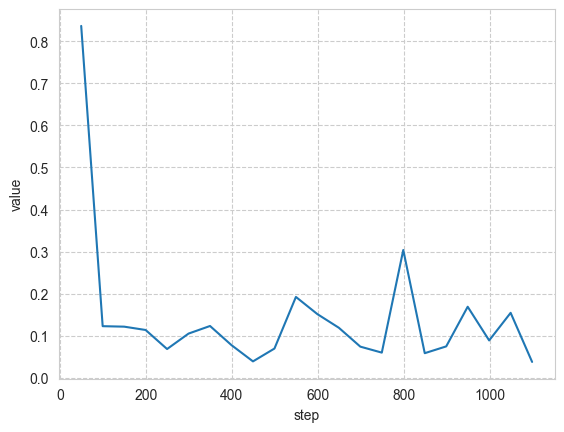

In [5]:
sns.lineplot(df.query("name == 'train_loss'"), x="step", y="value")
plt.grid(linestyle="--")
plt.show()

## Implementation: `tbparse`
For a simpler implementation, we can use the [`tbparse`](https://github.com/j3soon/tbparse) library (installable via `pip`).

In [6]:
from tbparse import SummaryReader

log_dir = "."
reader = SummaryReader(log_dir)
df = reader.scalars
df.head()

,step,tag,value
0,49,epoch,0.0
1,99,epoch,0.0
2,149,epoch,0.0
3,199,epoch,0.0
4,249,epoch,0.0


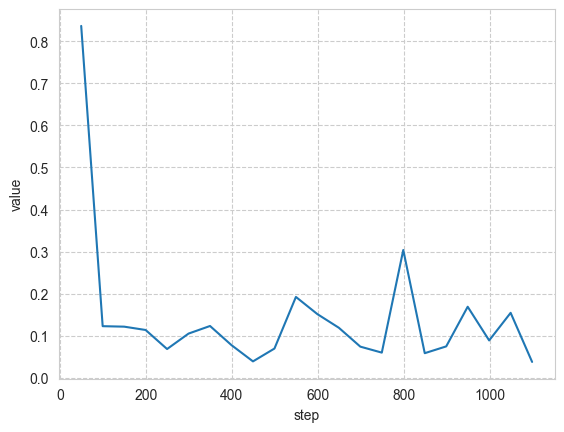

In [7]:
sns.lineplot(df.query("tag == 'train_loss'"), x="step", y="value")
plt.grid(linestyle="--")
plt.show()